In [1]:
import pdfplumber
import pandas as pd
import re
import os

In [2]:
column_names = ["club",	"last_name", "first_name", "position", "base_salary", "guaranteed_compensation"]

positions = ["F", "M", "D", "F", "G"]

clubs = ['Atlanta United', 'Austin FC', 'Charlotte FC', 'Chicago Fire', 'Chivas USA',
         'Colorado Rapids', 'Columbus Crew', 'DC United', 'FC Cincinnati',
         'FC Dallas', 'Houston Dynamo', 'Inter Miami', 'LA Galaxy', 'Los Angeles FC',
         'Major League Soccer', 'Minnesota United', 'Montreal Impact',
         'Nashville SC', 'New England Revolution', 'New York City FC',
         'New York Red Bulls', 'Orlando City SC', 'Philadelphia Union',
         'Portland Timbers', 'Real Salt Lake', 'San Jose Earthquakes',
         'Seattle Sounders FC', 'Sporting Kansas City', 'St. Louis City SC',
         'Toronto FC', 'Vancouver Whitecaps', 'Pool']

club_abr = {
    'ATL': 'Atlanta United',
    'AUS': 'Austin FC',
    'CLT': 'Charlotte FC',
    'CHI': 'Chicago Fire',
    'CHV': 'Chivas USA',
    'COL': 'Colorado Rapids',
    'CLB': 'Columbus Crew',
    'DC': 'DC United',
    'CIN': 'FC Cincinnati',
    'DAL': 'FC Dallas',
    'HOU': 'Houston Dynamo',
    'MIA': 'Inter Miami',
    'LA': 'LA Galaxy',
    'LAFC': 'Los Angeles FC',
    'MLS': 'Major League Soccer',
    'MIN': 'Minnesota United',
    'MTL': 'Montreal Impact',
    'NSH': 'Nashville SC',
    'NE': 'New England Revolution',
    'NYCFC': 'New York City FC',
    'NYRB': 'New York Red Bulls',
    'ORL': 'Orlando City SC',
    'PHI': 'Philadelphia Union',
    'POR': 'Portland Timbers',
    'RSL': 'Real Salt Lake',
    'SJ': 'San Jose Earthquakes',
    'SEA': 'Seattle Sounders FC',
    'SKC': 'Sporting Kansas City',
    'STL': 'St. Louis City SC',
    'TOR': 'Toronto FC',
    'VAN': 'Vancouver Whitecaps',
    'Pool': 'Pool'
}

team_region_mapping = {
    'Atlanta United': 'Eastern',
    'Austin FC': 'Western',
    'Charlotte FC': 'Eastern',
    'Chicago Fire': 'Eastern',
    'Chivas USA': 'Western',
    'Colorado Rapids': 'Western',
    'Columbus Crew': 'Eastern',
    'DC United': 'Eastern',
    'FC Cincinnati': 'Eastern',
    'FC Dallas': 'Western',
    'Houston Dynamo': 'Western',
    'Inter Miami': 'Eastern',
    'LA Galaxy': 'Western',
    'Los Angeles FC': 'Western',
    'Major League Soccer': 'N/A',
    'Minnesota United': 'Western',
    'Montreal Impact': 'Eastern',
    'Nashville SC': 'Western',
    'New England Revolution': 'Eastern',
    'New York City FC': 'Eastern',
    'New York Red Bulls': 'Eastern',
    'Orlando City SC': 'Eastern',
    'Philadelphia Union': 'Eastern',
    'Portland Timbers': 'Western',
    'Real Salt Lake': 'Western',
    'San Jose Earthquakes': 'Western',
    'Seattle Sounders FC': 'Western',
    'Sporting Kansas City': 'Western',
    'St. Louis City SC': 'Western',
    'Toronto FC': 'Eastern',
    'Vancouver Whitecaps': 'Western',
    'Pool': 'N/A'
}

def combine_elements(source_list, index1, index2):
    out_str = source_list[index1] + source_list[index2]
    del source_list[index2]
    source_list[index1] = out_str
    return source_list
    

def get_best_match(entry, option_list=clubs):

    if entry is None:
        return None
    best_match = None
    match_distance = float('inf')

    for option in option_list:
        distance = calc_lev_distance(entry, option)
        

        if distance < match_distance:
            best_match = option
            match_distance = distance


    return best_match

def calc_lev_distance(string1, string2):
    try:
        m = len(string1)
        n = len(string2)
    except TypeError:
        return(string1)

    # Create a matrix of size (m+1)x(n+1) to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Calculate the distances using dynamic programming
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if string1[i - 1] == string2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    # Return the Levenshtein distance between the two strings
    return dp[m][n]

In [3]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2018.pdf')
pages = pdf.pages
mls_salaries_2018_df = pd.DataFrame(columns=column_names)
for page in pdf.pages:
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 9})
        del table[:4]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)
            line = combine_elements(line, 4, 5)
            line = combine_elements(line, 5, 6)
            if len(line) != 6:
                line = combine_elements(line, 0, 1)
            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2018_df = pd.concat([mls_salaries_2018_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2018_df["position"] = mls_salaries_2018_df["position"].str.extract(r'([A-Z])')
mls_salaries_2018_df.position = mls_salaries_2018_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2018_df["base_salary"] = pd.to_numeric(mls_salaries_2018_df["base_salary"])
mls_salaries_2018_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2018_df["guaranteed_compensation"])
mls_salaries_2018_df["base_salary"] = mls_salaries_2018_df["base_salary"] / 100
mls_salaries_2018_df["guaranteed_compensation"] = mls_salaries_2018_df["guaranteed_compensation"] / 100
mls_salaries_2018_df

club     last_name first_name position  base_salary  \
0      New York Red Bulls         Abang    Anatole        F     68927.00   
1        New York City FC  Abdul-Salaam       Saad        D    106480.00   
2           Columbus Crew           Abu   Mohammed        M    175008.00   
3           Columbus Crew      Abubakar      Lalas        D     68250.04   
4       PhiladelphiaUnion         Accam      David        F   1250000.04   
..                    ...           ...        ...      ...          ...   
689             FC Dallas       Ziegler       Reto        D    750000.00   
690                  LAFC     Zimmerman     Walker        D    235000.00   
691        Atlanta United         Zizzo        Sal        D    129999.96   
692             FC Dallas        Zobeck       Kyle        G     67500.00   
693  Sporting Kansas City          Zusi     Graham        D    750000.00   

     guaranteed_compensation  
0                   68927.00  
1                  120230.00  
2                  181258.00  
3                   75750.04  
4                 1250000.04  
..                       ...  
689                800000.00  
690                235000.00  
691                129999.96  
692                 67500.00  
693                782102.27  

[694 rows x 6 columns]

In [4]:
mls_salaries_2018_df.to_csv('data/mls_salaries/mls-salaries-2018.csv', index=False)

In [5]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2019.pdf')
pages = pdf.pages
mls_salaries_2019_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 5})
        if i == 0:
            del table[:1]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)

            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2019_df = pd.concat([mls_salaries_2019_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2019_df["position"] = mls_salaries_2019_df["position"].str.extract(r'([A-Z])')
mls_salaries_2019_df.position = mls_salaries_2019_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2019_df["base_salary"] = pd.to_numeric(mls_salaries_2019_df["base_salary"])
mls_salaries_2019_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2019_df["guaranteed_compensation"])
mls_salaries_2019_df["base_salary"] = mls_salaries_2019_df["base_salary"] / 100
mls_salaries_2019_df["guaranteed_compensation"] = mls_salaries_2019_df["guaranteed_compensation"] / 100
mls_salaries_2019_df

club     last_name first_name position  base_salary  \
0       PhiladelphiaUnion      Aaronson    Brenden        F     70000.08   
1     Seattle Sounders FC  Abdul-Salaam       Saad        D     70250.04   
2         Colorado Rapids      Abubakar      Lalas        D    135000.00   
3           Columbus Crew         Accam      David        F   1010004.00   
4         Colorado Rapids        Acosta     Kellyn        M    549999.96   
..                    ...           ...        ...      ...          ...   
709             FC Dallas       Ziegler       Reto        D    820000.08   
710                  LAFC     Zimmerman     Walker        D    600000.00   
711             FC Dallas        Zobeck       Kyle        G     70875.00   
712             LA Galaxy         Zubak      Ethan        F     75000.00   
713  Sporting Kansas City          Zusi     Graham        M    625000.08   

     guaranteed_compensation  
0                   98309.48  
1                   70250.04  
2                  144937.50  
3                 1137920.00  
4                  664999.96  
..                       ...  
709                870000.08  
710                600000.00  
711                 70875.00  
712                 78125.00  
713                688333.41  

[714 rows x 6 columns]

In [6]:
mls_salaries_2019_df.to_csv('data/mls_salaries/mls-salaries-2019.csv', index=False)

In [7]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2020.pdf')
pages = pdf.pages
mls_salaries_2020_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
      table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 8})
        
      del table[:2]
      for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 2, 3)

            if len(line) == 7:
                  line = combine_elements(line, 2, 3)
            if len(line) == 5:
                  for pos in positions:
                        if line[2].endswith(pos):
                              line[2] = line[2][:-len(pos)]
                              line.insert(3, pos)
                              break

            # places player name in correct position
            player_name = line[:2]
            del line[:2]
            line.insert(1, player_name[0])
            line.insert(2, player_name[1])

            # combines last 3 spaces to then split with $
            if len(line) != 6:
                   line.insert(3, 'G')
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2020_df = pd.concat([mls_salaries_2020_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2020_df.position = mls_salaries_2020_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2020_df["position"] = mls_salaries_2020_df["position"].str.extract(r'([A-Z])')
mls_salaries_2020_df

club     last_name first_name position base_salary  \
0       PhiladelphiaUnion      Aaronson    Brenden        M       85000   
1           FC Cincinnati  Abdul-Salaam       Saad        D       81375   
2               DC United           Abu   Mohammed        M       81375   
3         Colorado Rapids      Abubakar      Lalas        D      145000   
4            Nashville SC         Accam      David        F      875000   
..                    ...           ...        ...      ...         ...   
773     New York RedBulls                     Kaku        M      850000   
774       Orlando City SC                  Robinho        M      198000   
775    Philadelphia Union                  Ilsinho        M      425000   
776  San Jose Earthquakes                   Judson        M      320000   
777            Toronto FC                     Auro        D      300000   

    guaranteed_compensation  
0                    103309  
1                     90042  
2                     81375  
3                    154937  
4                   1002916  
..                      ...  
773                  850000  
774                  205500  
775                  476250  
776                  325000  
777                  328750  

[778 rows x 6 columns]

In [8]:
mls_salaries_2020_df.to_csv('data/mls_salaries/mls-salaries-2020.csv', index=False)

In [9]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2021.pdf')
pages = pdf.pages
mls_salaries_2021_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        if i == 0:
            del table[:2]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2021_df = pd.concat([mls_salaries_2021_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2021_df["position"] = mls_salaries_2021_df["position"].str.extract(r'([A-Z])')
mls_salaries_2021_df.position = mls_salaries_2021_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2021_df["base_salary"] = mls_salaries_2021_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df["guaranteed_compensation"] = mls_salaries_2021_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df

club      last_name      first_name position  base_salary  \
0         Atlanta United          Adams   Mohammed "Mo"        M     121000.0   
1         Atlanta United        Ambrose           Mikey        D      81375.0   
2         Atlanta United         Araujo            Luiz        F    3600000.0   
3         Atlanta United          Barco        Ezequiel        M    1875000.0   
4         Atlanta United          Bauer            Josh        D      63547.0   
..                   ...            ...             ...      ...          ...   
866  Vancouver Whitecaps  Sousa e Silva  Caio Alexandre        M     500000.0   
867  Vancouver Whitecaps        Teibert         Russell        M     350000.0   
868  Vancouver Whitecaps    Veselinovic           Ranko        D     360000.0   
869  Vancouver Whitecaps           Vite           Pedro        M     556000.0   
870  Vancouver Whitecaps          White           Brian        F     216000.0   

     guaranteed_compensation  
0                   141000.0  
1                    81375.0  
2                  3941667.0  
3                  2358333.0  
4                    63547.0  
..                       ...  
866                 539583.0  
867                 387500.0  
868                 445500.0  
869                 609997.0  
870                 216000.0  

[871 rows x 6 columns]

In [10]:
mls_salaries_2021_df.to_csv('data/mls_salaries/mls-salaries-2021.csv', index=False)

In [11]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2022.pdf')
pages = pdf.pages
mls_salaries_2022_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 9})
        if i == 0:
            del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2022_df = pd.concat([mls_salaries_2022_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2022_df["position"] = mls_salaries_2022_df["position"].str.extract(r'([A-Z])')
mls_salaries_2022_df.position = mls_salaries_2022_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2022_df["last_name"] = mls_salaries_2022_df["last_name"].str.replace(r'^[a-z]+', '', regex=True)
mls_salaries_2022_df["base_salary"] = mls_salaries_2022_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df["guaranteed_compensation"] = mls_salaries_2022_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df

club          last_name    first_name position  base_salary  \
0    Atlanta United             Almada        Thiago        F    1650000.0   
1    Atlanta United             Alonso       Osvaldo        M      84000.0   
2    Atlanta United            Ambrose         Mikey        D      85444.0   
3    Atlanta United             Araujo          Luiz        F    3600000.0   
4    Atlanta United              Barco      Ezequiel        M    2200000.0   
..              ...                ...           ...      ...          ...   
889  Vancouver Whit  Scoaupssa e Silva  Caio Alexand        M     500000.0   
890  Vancouver Whit        Tceaibpesrt       Russell        M     400000.0   
891  Vancouver Whit    Vceaspeslinovic         Ranko        D     405000.0   
892  Vancouver Whit           Vcitaeps         Pedro        M     556000.0   
893  Vancouver Whit          Wcahpites         Brian        F     456000.0   

     guaranteed_compensation  
0                  2332000.0  
1                    84000.0  
2                    85444.0  
3                  4480333.0  
4                  2200000.0  
..                       ...  
889                 562500.0  
890                 449375.0  
891                 490500.0  
892                 609997.0  
893                 456000.0  

[894 rows x 6 columns]

In [12]:
mls_salaries_2022_df.to_csv('data/mls_salaries/mls-salaries-2022.csv', index=False)

In [13]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2023.pdf')
pages = pdf.pages
mls_salaries_2023_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        
        del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2023_df = pd.concat([mls_salaries_2023_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2023_df.position = mls_salaries_2023_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2023_df["position"] = mls_salaries_2023_df["position"].str.extract(r'([A-Z])')
mls_salaries_2023_df["base_salary"] = mls_salaries_2023_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df["guaranteed_compensation"] = mls_salaries_2023_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df

club last_name first_name position  base_salary  \
0         Atlanta United  McFadden      Aiden        D      85444.0   
1         Atlanta United   Fortune      Ajani        M      67360.0   
2         Atlanta United    Sejdic       Amar        D      85444.0   
3         Atlanta United    Gutman     Andrew        D     350000.0   
4         Atlanta United     Guzan       Brad        G     600000.0   
..                   ...       ...        ...      ...          ...   
864  Vancouver Whitecaps   Córdova     Sergio        F     981818.0   
865  Vancouver Whitecaps    Becher      Simon        F      67360.0   
866  Vancouver Whitecaps     Hasal     Thomas        G     203000.0   
867  Vancouver Whitecaps  Blackmon    Tristan        D     400000.0   
868  Vancouver Whitecaps   Takaoka      Yohei        G     179520.0   

     guaranteed_compensation  
0                    85444.0  
1                    67360.0  
2                    92111.0  
3                   381250.0  
4                   612500.0  
..                       ...  
864                1050568.0  
865                  70485.0  
866                 222412.0  
867                 451208.0  
868                 297233.0  

[869 rows x 6 columns]

In [14]:
mls_salaries_2023_df.to_csv('data/mls_salaries/mls-salaries-2023.csv', index=False)

In [15]:
directory = "data/mls_salaries/"
mls_salaries_df = pd.DataFrame()
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        year = filename[-8:-4]  # Extract the year from the filename
        
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(filepath)
        
        # Add a 'Year' column with the extracted year value
        temp_df['year'] = year
        
        # Append the temporary DataFrame to the combined DataFrame
        mls_salaries_df = pd.concat([mls_salaries_df, temp_df], ignore_index=True)
mls_salaries_df

club          last_name    first_name position  base_salary  \
0                 VAN           Abdallah         Aminu        M      46500.0   
1                 DAL             Acosta        Kellyn        M      46500.0   
2                 VAN           Adekugbe        Samuel        D      46500.0   
3                 TOR      Agbossoumonde          Gale        D      46500.0   
4                  NE            Agudelo          Juan        F     145000.0   
...               ...                ...           ...      ...          ...   
10368  Vancouver Whit  Scoaupssa e Silva  Caio Alexand        M     500000.0   
10369  Vancouver Whit        Tceaibpesrt       Russell        M     400000.0   
10370  Vancouver Whit    Vceaspeslinovic         Ranko        D     405000.0   
10371  Vancouver Whit           Vcitaeps         Pedro        M     556000.0   
10372  Vancouver Whit          Wcahpites         Brian        F     456000.0   

       guaranteed_compensation  year  
0                     46500.00  2013  
1                     70500.00  2013  
2                     51500.00  2013  
3                     53166.67  2013  
4                    175000.00  2013  
...                        ...   ...  
10368                562500.00  2022  
10369                449375.00  2022  
10370                490500.00  2022  
10371                609997.00  2022  
10372                456000.00  2022  

[10373 rows x 7 columns]

In [16]:
mls_salaries_df['club'] = mls_salaries_df['club'].replace(club_abr)
mls_salaries_df.position = mls_salaries_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_df.club = mls_salaries_df.club.apply(lambda x: get_best_match(x, clubs))
mls_salaries_df['conference'] = mls_salaries_df['club'].map(team_region_mapping)

In [17]:
mls_salaries_df.to_csv('data/mls_salaries_masterlist.csv', index=False)

In [18]:
mls_salaries_df = pd.read_csv("data/mls_salaries_masterlist.csv")
mls_salaries_df.sample(20)

club    last_name first_name position  base_salary  \
4542        Orlando City SC     Nocerino    Antonio        M     800000.0   
2377         Houston Dynamo       Taylor   Jermaine        D      57500.0   
8198    Vancouver Whitecaps         Egbo      David        F      63547.0   
8741        Colorado Rapids     Gersbach       Alex        D     230000.0   
794                    Pool    Marinelli     Carlos        M     165000.0   
5021          FC Cincinnati         Gyau        Joe        M     148200.0   
3979       Portland Timbers      Manning    Anthony        D      52500.0   
7954        Orlando City SC         Nani       Luis        F    2333333.0   
8510   San Jose Earthquakes   Pitchkolan      Aaron        D      50000.0   
513               DC United  Thorrington       John        M     150000.0   
9182     New York Red Bulls    Fernandez       Omir        F     161000.0   
4524        Orlando City SC          Aja       Jose        D     216000.0   
6409         Real Salt Lake      Morales     Javier        M     240000.0   
2352              DC United     Shanosky      Conor        D      55000.0   
198          Real Salt Lake          Gil       Luis        M     118750.0   
9181     New York Red Bulls       Nocita    Matthew        D      88200.0   
10205        Real Salt Lake        Ojeda     Braian        M     550000.0   
9932    Major League Soccer  Hcucnedrley       Matt        F     110000.0   
2898   San Jose Earthquakes      Salinas       Shea        M     145000.0   
2553     Philadelphia Union         Cruz      Danny        M     125000.0   

       guaranteed_compensation  year conference  
4542                 850000.00  2017    Eastern  
2377                  62500.00  2011    Western  
8198                  63547.00  2021    Western  
8741                 270433.00  2023    Western  
794                  165000.00  2007        NaN  
5021                 168640.00  2019    Eastern  
3979                  52500.00  2016    Western  
7954                2486250.00  2021    Eastern  
8510                  51250.00  2009    Western  
513                  150000.00  2013    Eastern  
9182                 176000.00  2023    Eastern  
4524                 216000.00  2017    Eastern  
6409                 240000.00  2008    Western  
2352                  69218.83  2011    Eastern  
198                  213833.33  2013    Western  
9181                  88200.00  2023    Eastern  
10205                608653.00  2022    Western  
9932                 119000.00  2022        NaN  
2898                 148333.33  2015    Western  
2553                 131666.67  2015    Eastern

In [19]:
mlb_salaries_df = pd.read_csv("data/mlb_salaries.csv")
mlb_salaries_df.sample(20)

playerid       player_name  weight  height bats throws  season league  \
23320  sheffga01    Gary Sheffield     190      71    R      R    1990     AL   
24137  spiveju01     Junior Spivey     185      72    R      R    2005     NL   
5886   davisch01       Chili Davis     195      75    B      R    1995     AL   
18267  nippeal01         Al Nipper     188      72    R      R    1988     NL   
2198   billich01  Chad Billingsley     240      73    R      R    2013     NL   
17101  mirabdo01    Doug Mirabelli     205      73    R      R    2007     AL   
11160  hernake01   Keith Hernandez     180      72    L      L    1985     NL   
16836  micelda01        Dan Miceli     185      73    R      R    2003     AL   
26794  weaveje01       Jeff Weaver     200      77    R      R    2007     AL   
21452   rijojo01         Jose Rijo     200      73    R      R    1986     AL   
587    anderla02    Larry Andersen     200      75    R      R    1991     NL   
20923   rapppa01          Pat Rapp     195      75    R      R    1999     AL   
1518   beckejo02      Josh Beckett     230      77    R      R    2002     NL   
24836  tablepa01        Pat Tabler     175      75    R      R    1989     AL   
2071   berryse01        Sean Berry     200      71    R      R    1996     NL   
26481  wakefti01     Tim Wakefield     210      74    R      R    2003     AL   
24498  strando01      Doug Strange     170      74    B      R    1996     AL   
10319  hammoch01     Chris Hammond     190      73    L      L    1995     NL   
16268  mcclubo01       Bob McClure     170      71    R      L    1988     NL   
10489  harkemi01       Mike Harkey     220      77    R      R    1990     NL   

      teamid                  team                      franchise    salary  
23320    ML4     Milwaukee Brewers              Milwaukee Brewers    115000  
24137    WAS  Washington Nationals           Washington Nationals   2125000  
5886     CAL     California Angels  Los Angeles Angels of Anaheim   3800000  
18267    CHN          Chicago Cubs                   Chicago Cubs    397000  
2198     LAN   Los Angeles Dodgers            Los Angeles Dodgers  11000000  
17101    BOS        Boston Red Sox                 Boston Red Sox    750000  
11160    NYN         New York Mets                  New York Mets   1100000  
16836    NYA      New York Yankees               New York Yankees    350000  
26794    SEA      Seattle Mariners               Seattle Mariners   8325000  
21452    OAK     Oakland Athletics              Oakland Athletics     85000  
587      SDN      San Diego Padres               San Diego Padres   2000000  
20923    BOS        Boston Red Sox                 Boston Red Sox   1650000  
1518     FLO       Florida Marlins                Florida Marlins   2156250  
24836    KCA    Kansas City Royals             Kansas City Royals    825000  
2071     HOU        Houston Astros                 Houston Astros    995000  
26481    BOS        Boston Red Sox                 Boston Red Sox   4000000  
24498    SEA      Seattle Mariners               Seattle Mariners    380000  
10319    FLO       Florida Marlins                Florida Marlins   1025000  
16268    MON        Montreal Expos           Washington Nationals    500000  
10489    CHN          Chicago Cubs                   Chicago Cubs    104500

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

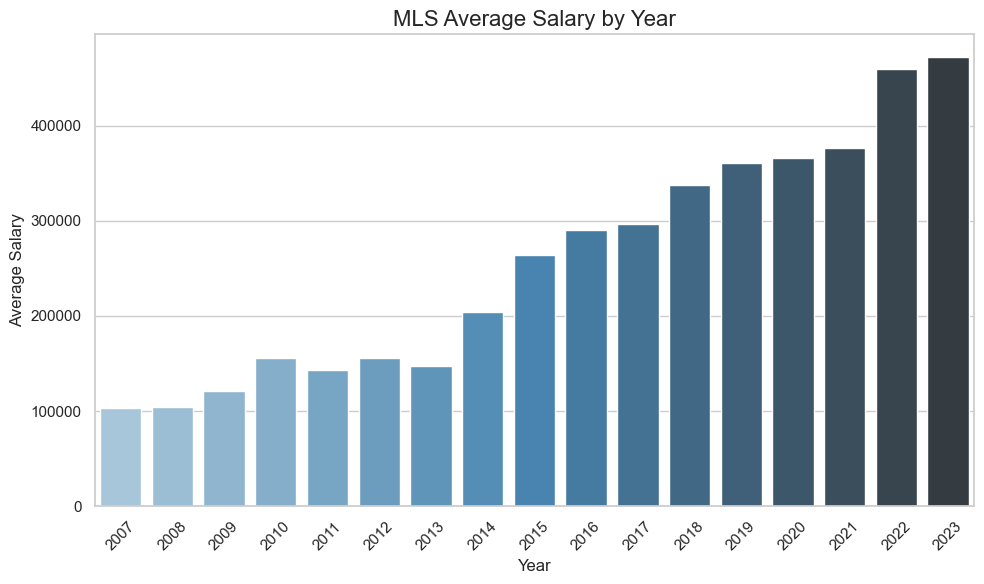

In [21]:
# Calculate the average salary for each year
average_salary_by_year = mls_salaries_df.groupby('year')['base_salary'].mean()


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=average_salary_by_year.index, y=average_salary_by_year.values, palette="Blues_d")
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Year', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

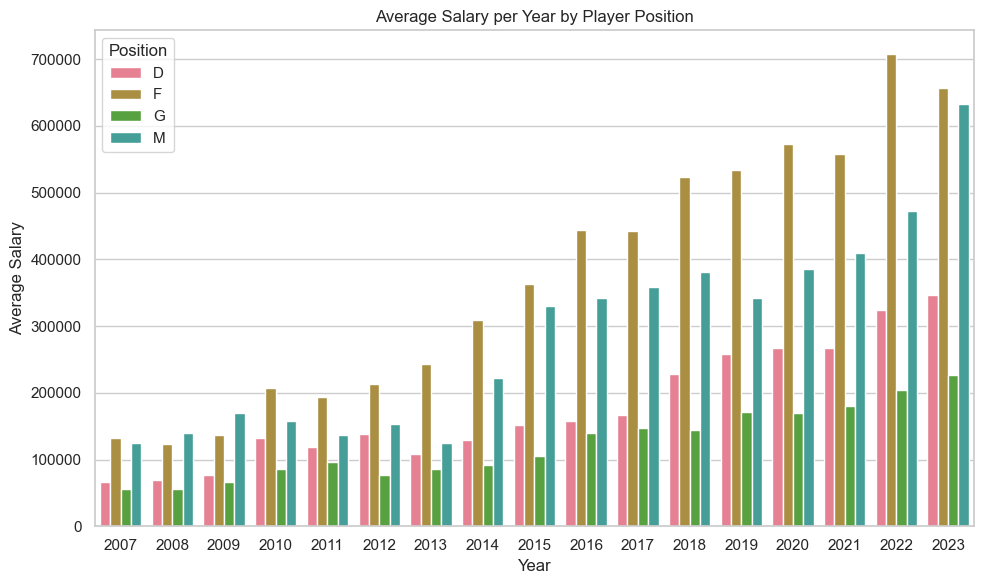

In [22]:
# Calculate average salary per year and position
average_salary = mls_salaries_df.groupby(['year', 'position'])['base_salary'].mean().reset_index()

pivot_table = average_salary.pivot_table(index='year', columns='position', values='base_salary', fill_value=0)
melted_data = average_salary.melt(id_vars=['year', 'position'], value_vars='base_salary', var_name='Metric', value_name='Average Salary')

# Stacked bar graph using sea
plt.figure(figsize=(10, 6))
sns.set_palette('husl')
sns.barplot(data=melted_data, x='year', y='Average Salary', hue='position')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Average Salary per Year by Player Position')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

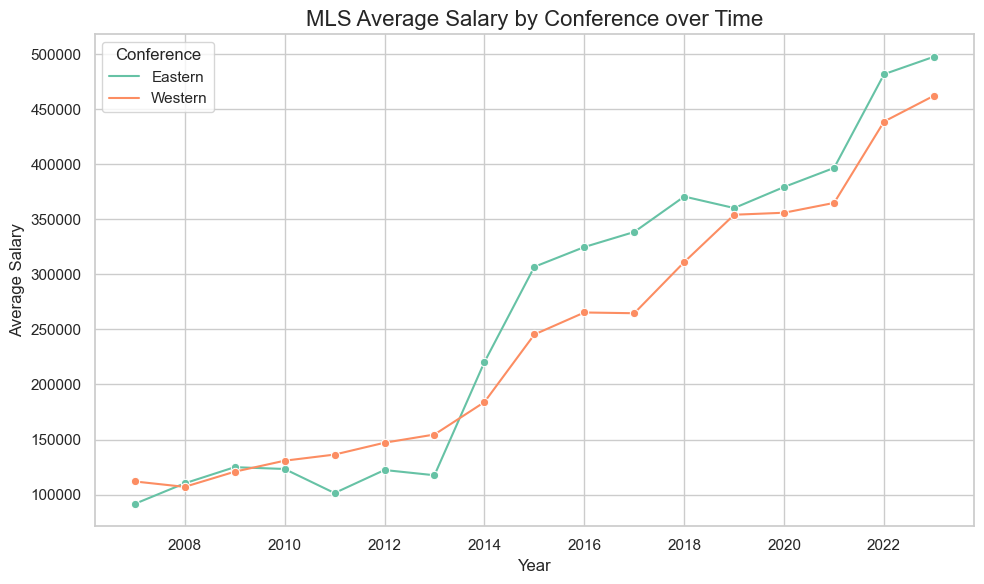

In [23]:
average_salary_by_region_year = mls_salaries_df.groupby(['conference', 'year'])['base_salary'].mean().reset_index()

sns.set(style="whitegrid")

# Create the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_salary_by_region_year, x='year', y='base_salary', hue='conference', palette='Set2', marker='o')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Conference over Time', fontsize=16)
plt.legend(title='Conference')
plt.tight_layout()

plt.show()

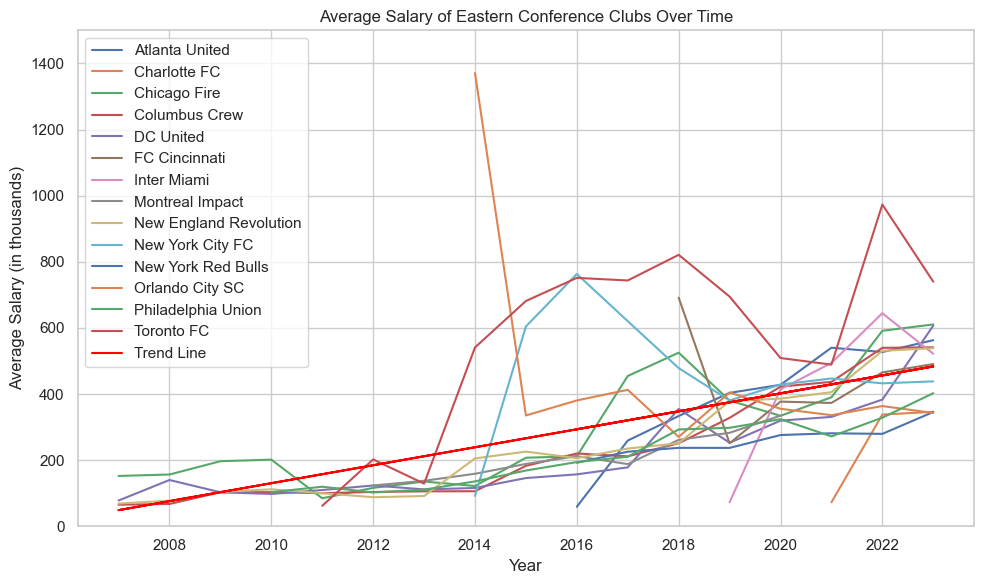

In [24]:

# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Eastern']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Eastern Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

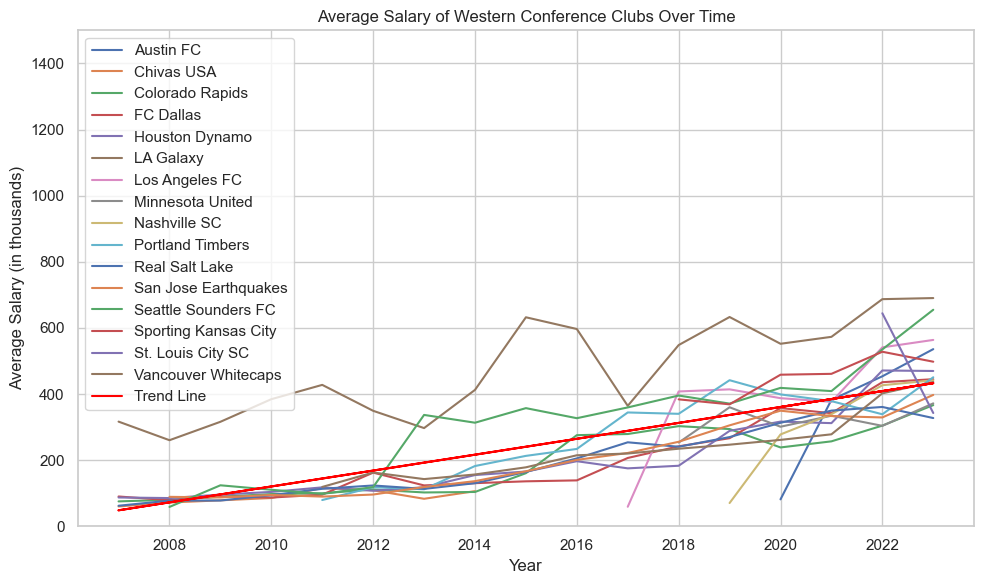

In [25]:
# Filter Western conference clubs
western_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Western']

# Calculate yearly average salary for each club
average_salary = western_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

# Line graph with trend line
plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Western Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

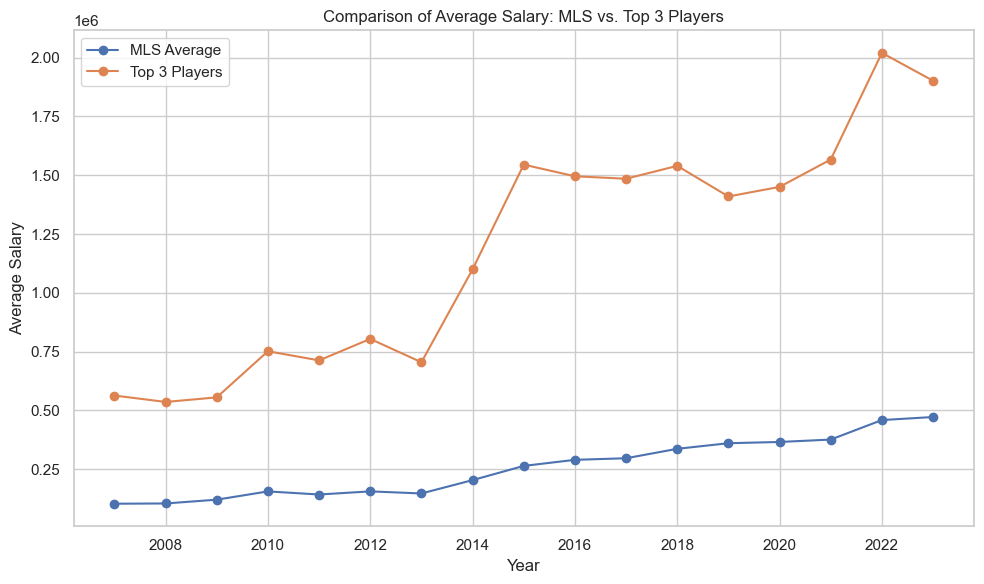

In [26]:
# Calculate average salary per year for the MLS
average_salary_mls = mls_salaries_df.groupby('year')['base_salary'].mean().reset_index()

# Calculate average salary per year for the top 3 players of each club
top_3_players = mls_salaries_df.groupby(['year', 'club']).apply(lambda x: x.nlargest(3, 'base_salary')).reset_index(drop=True)
average_salary_top_3 = top_3_players.groupby('year')['base_salary'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_salary_mls['year'], average_salary_mls['base_salary'], marker='o', label='MLS Average')
# average_salary_mls['base_salary'] /= 1_000_000
plt.plot(average_salary_top_3['year'], average_salary_top_3['base_salary'], marker='o', label='Top 3 Players')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Comparison of Average Salary: MLS vs. Top 3 Players')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
average_salary_top_3['base_salary'].fillna(method='ffill', inplace=True)
average_salary_top_3['year'] = pd.to_datetime(average_salary_top_3['year'], format='%Y')
average_salary_top_3.set_index('year', inplace=True)

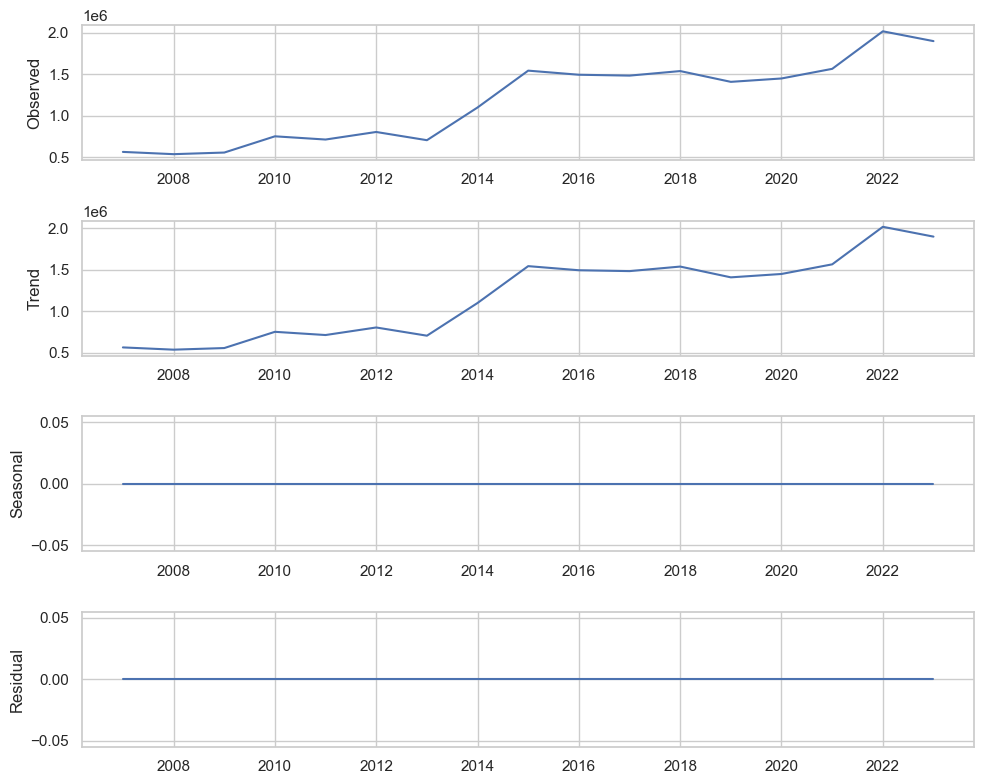

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(average_salary_top_3['base_salary'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(average_salary_top_3.index, decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(average_salary_top_3.index, decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(average_salary_top_3.index, decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(average_salary_top_3.index, decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

In [29]:
average_salary_mls['base_salary'].fillna(method='ffill', inplace=True)
average_salary_mls['year'] = pd.to_datetime(average_salary_mls['year'], format='%Y')
average_salary_mls.set_index('year', inplace=True)

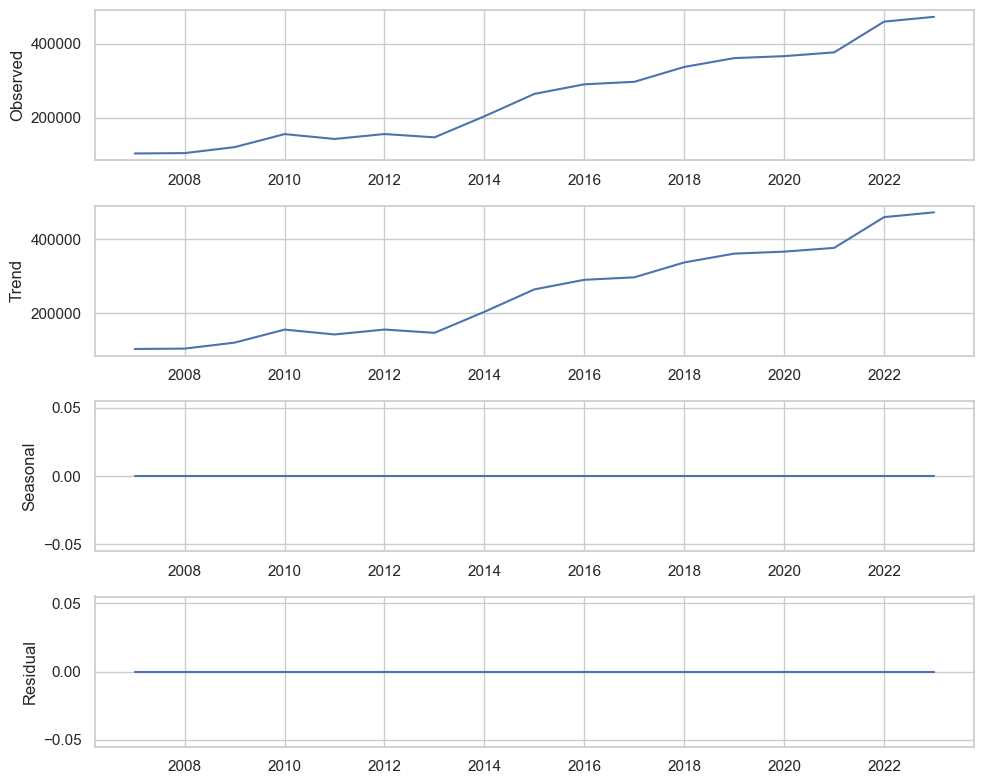

In [30]:
# Decompose the time series
decomposition = seasonal_decompose(average_salary_mls['base_salary'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(average_salary_mls.index, decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(average_salary_mls.index, decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(average_salary_mls.index, decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(average_salary_mls.index, decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Step 1: Split the Data
train_data = average_salary_mls.loc['2000':'2019']
test_data = average_salary_mls.loc['2020':]

# Step 2: Select Evaluation Metric
eval_metric = mean_squared_error

# Step 3: Choose Models
models = {
    'ARIMA': ARIMA(endog=train_data['base_salary'], order=(1, 1, 1)),
    'SARIMA': SARIMAX(train_data['base_salary'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

In [32]:
# Step 4: Train and Evaluate Models
results = {}
for model_name, model in models.items():
    if model_name == 'ARIMA':
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(test_data))
        predictions = forecast.predicted_mean
    elif model_name == 'SARIMA':
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    else:
        model.fit(train_data.index.values.astype(float).reshape(-1, 1), train_data['base_salary'])
        predictions = model.predict(test_data.index.values.astype(float).reshape(-1, 1))
    error = eval_metric(test_data['base_salary'], predictions)
    results[model_name] = error

# Step 5: Compare and Select Best Model
best_model = min(results, key=results.get)
best_error = results[best_model]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [33]:

# Step 6: Further Analysis

# Step 7: Finalize and Validate

# Print results
print("Model Comparison Results:")
for model, error in results.items():
    print(f"{model}: {error:.6f}")

print(f"\nBest Model: {best_model}")
print(f"Best Error: {best_error:.6f}")

Model Comparison Results:
ARIMA: 820112048.063249
SARIMA: 1842660503.780255
Linear Regression: 1055242523.934176
Random Forest: 7340982639.775282

Best Model: ARIMA
Best Error: 820112048.063249


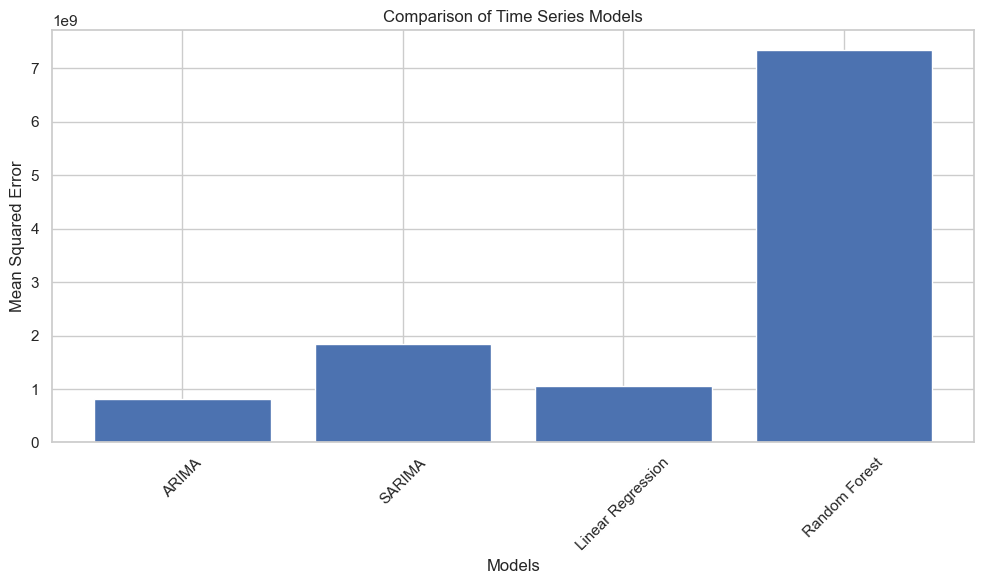

In [34]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Time Series Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Step 1: Split the Data
train_data = average_salary_top_3.loc['2000':'2019']
test_data = average_salary_top_3.loc['2020':]

# Step 2: Select Evaluation Metric
eval_metric = mean_squared_error

# Step 3: Choose Models
models = {
    'ARIMA': ARIMA(endog=train_data['base_salary'], order=(1, 1, 1)),
    'SARIMA': SARIMAX(train_data['base_salary'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

In [36]:
# Step 4: Train and Evaluate Models
results = {}
for model_name, model in models.items():
    if model_name == 'ARIMA':
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(test_data))
        predictions = forecast.predicted_mean
    elif model_name == 'SARIMA':
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    else:
        model.fit(train_data.index.values.astype(float).reshape(-1, 1), train_data['base_salary'])
        predictions = model.predict(test_data.index.values.astype(float).reshape(-1, 1))
    error = eval_metric(test_data['base_salary'], predictions)
    results[model_name] = error

# Step 5: Compare and Select Best Model
best_model = min(results, key=results.get)
best_error = results[best_model]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [37]:
# Step 6: Further Analysis

# Step 7: Finalize and Validate

# Print results
print("Model Comparison Results:")
for model, error in results.items():
    print(f"{model}: {error:.6f}")

print(f"\nBest Model: {best_model}")
print(f"Best Error: {best_error:.6f}")

Model Comparison Results:
ARIMA: 180128098000.660614
SARIMA: 81844877841.508789
Linear Regression: 36962840262.209747
Random Forest: 133739598818.598450

Best Model: Linear Regression
Best Error: 36962840262.209747


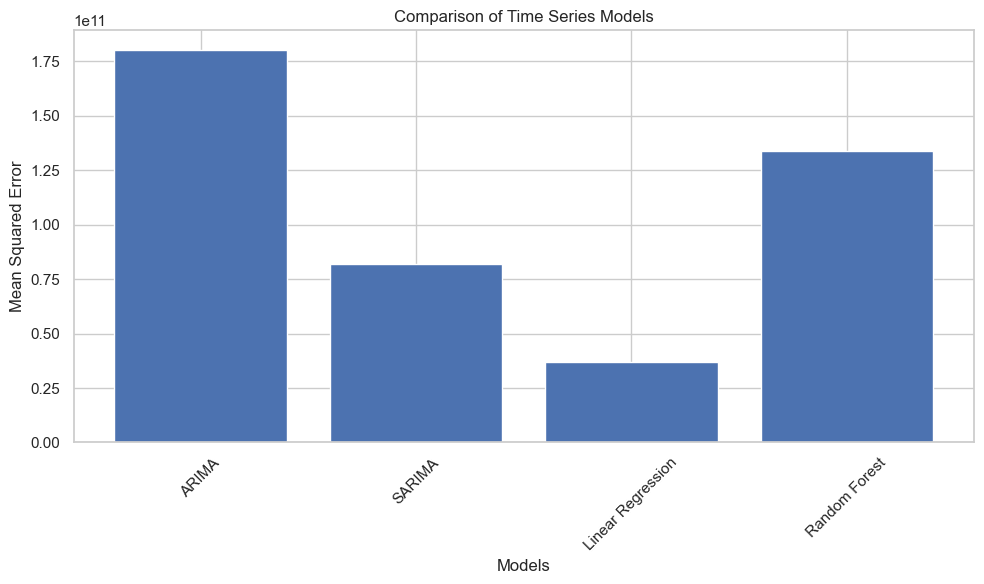

In [38]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Time Series Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
average_salary_mls

base_salary
year                     
2007-01-01  103715.181752
2008-01-01  104706.091366
2009-01-01  120874.220438
2010-01-01  155982.837956
2011-01-01  142840.144057
2012-01-01  156124.184242
2013-01-01  147238.192969
2014-01-01  204007.701189
2015-01-01  264402.689826
2016-01-01  290245.664018
2017-01-01  296977.736867
2018-01-01  337081.168401
2019-01-01  360865.324732
2020-01-01  366197.996144
2021-01-01  376390.464983
2022-01-01  459297.842282
2023-01-01  472225.507480

/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


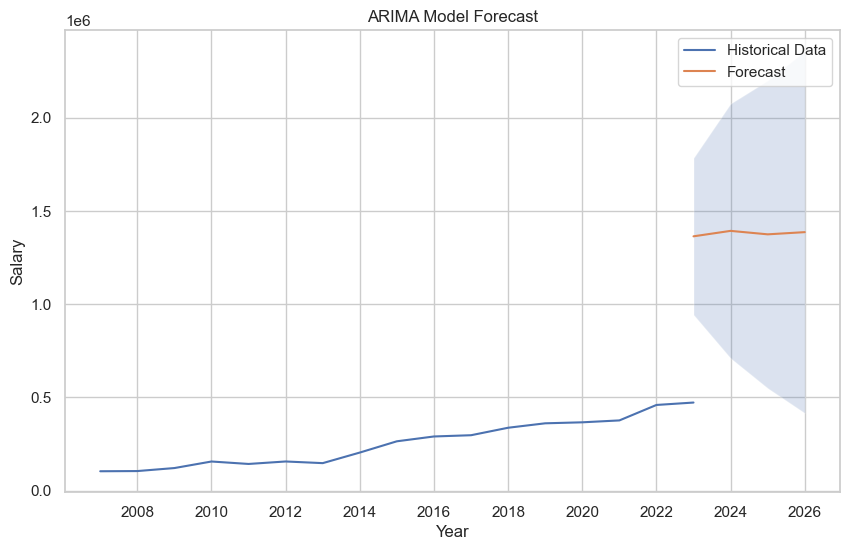

In [70]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
average_salary = mls_salaries_df.groupby('year')['base_salary'].mean().reset_index()
average_salary['base_salary'].fillna(method='ffill', inplace=True)
average_salary['year'] = pd.to_datetime(average_salary['year'], format='%Y')
average_salary.set_index('year', inplace=True)


# Train the ARIMA model on the entire dataset
model = ARIMA(average_salary['base_salary'], order=(1, 1, 1))
model_fit = model.fit()

# Generate forecasted values for the next 5 years
forecast_values = model_fit.forecast(steps=5)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()

# Create a time index for the forecasted period
forecast_index = pd.date_range(start='2023-01-01', periods=4, freq='AS-JAN')

lower_bound = confidence_interval.iloc[:, 0]
upper_bound = confidence_interval.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(average_salary.index, average_salary['base_salary'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.fill_between(forecast_index, lower_bound, upper_bound, alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Salary')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.grid(True)
plt.show()








In [ ]:
import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(mls_salaries_df)

#Saving results to HTML file
sweet_report.show_html('MLS_salary_report.html')

/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/Users/desaturation/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  f

Report MLS_salary_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


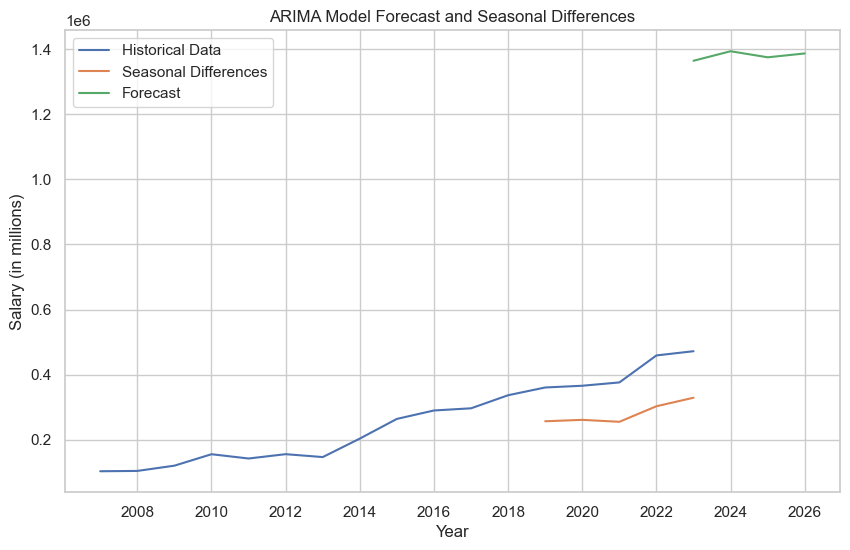

In [46]:
# Calculate the seasonal differences
seasonal_diff = average_salary_mls['base_salary'].diff(12)  # Assuming 12 seasons in a year

# Plot the historical data, seasonal differences, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(average_salary_mls.index, average_salary_mls['base_salary'], label='Historical Data')
plt.plot(average_salary_mls.index, seasonal_diff, label='Seasonal Differences')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.xlabel('Year')
plt.ylabel('Salary (in millions)')
plt.title('ARIMA Model Forecast and Seasonal Differences')
plt.legend()
plt.grid(True)
plt.show()

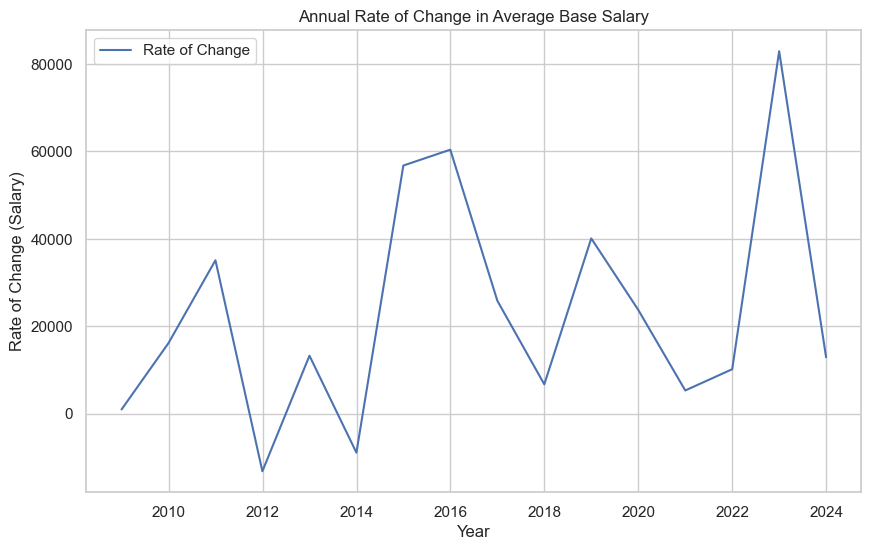

In [47]:
annual_average_salary = average_salary_mls['base_salary'].resample('A').mean()

# Calculate the annual differences
annual_diff = annual_average_salary.diff()

# Plot the annual differences
plt.figure(figsize=(10, 6))
plt.plot(annual_diff.index, annual_diff.values, label='Rate of Change')
plt.xlabel('Year')
plt.ylabel('Rate of Change (Salary)')
plt.title('Annual Rate of Change in Average Base Salary')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
annual_diff_percent = annual_average_salary.pct_change() * 100

# Create a DataFrame to display the results
diff_table = pd.DataFrame({'Year': annual_diff_percent.index.year,
                           'Rate of Change (%)': annual_diff_percent.values})

# Display the table
print(diff_table)

    Year  Rate of Change (%)
0   2007                 NaN
1   2008            0.955414
2   2009           15.441441
3   2010           29.045579
4   2011           -8.425731
5   2012            9.299935
6   2013           -5.691617
7   2014           38.556238
8   2015           29.604269
9   2016            9.774097
10  2017            2.319440
11  2018           13.503851
12  2019            7.055914
13  2020            1.477746
14  2021            2.783322
15  2022           22.026960
16  2023            2.814658


In [49]:
average_salary_top_3['wage_rate'] = average_salary_top_3['base_salary'].pct_change() * 100

# Display the DataFrame
print(average_salary_top_3)

             base_salary  wage_rate
year                               
2007-01-01  5.635804e+05        NaN
2008-01-01  5.363247e+05  -4.836154
2009-01-01  5.557863e+05   3.628682
2010-01-01  7.519051e+05  35.286734
2011-01-01  7.130295e+05  -5.170279
2012-01-01  8.043033e+05  12.800847
2013-01-01  7.050417e+05 -12.341309
2014-01-01  1.100334e+06  56.066537
2015-01-01  1.545197e+06  40.429780
2016-01-01  1.495656e+06  -3.206144
2017-01-01  1.485169e+06  -0.701120
2018-01-01  1.539999e+06   3.691835
2019-01-01  1.409805e+06  -8.454203
2020-01-01  1.450564e+06   2.891127
2021-01-01  1.566968e+06   8.024720
2022-01-01  2.020291e+06  28.929965
2023-01-01  1.901777e+06  -5.866156


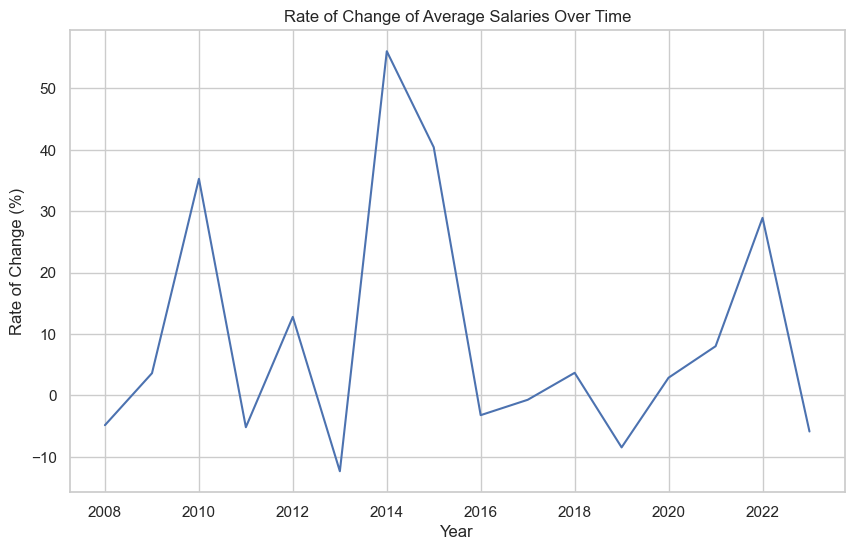

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(average_salary_top_3.index, average_salary_top_3['wage_rate'])
plt.xlabel('Year')
plt.ylabel('Rate of Change (%)')
plt.title('Rate of Change of Average Salaries Over Time')
plt.grid(True)
plt.show()

In [ ]:
# %pip install pandas_profiling  # Run this from Jupytor notebook Ignore the warnings if any 
from pandas_profiling import ProfileReport #restart the kernel if throws error
ProfileReport(mls_salaries_df)  

/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_7963/3051029572.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport #restart the kernel if throws error


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ProfileReport(top_3_players)  

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ProfileReport(mls_salaries_2023_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ProfileReport(mls_salaries_2023_df.groupby(["club"]).mean())

/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_13197/2085767446.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ProfileReport(mls_salaries_2023_df.groupby(["club"]).mean())


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ProfileReport(mls_salaries_2023_df.groupby(["club"]).sum())

/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_7963/4266430511.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ProfileReport(mls_salaries_2023_df.groupby(["club"]).sum())


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Ten Questions

#### How much would staffing an MLS team currently cost?
The average base salary in MLS is currently $13,678,800.  You can expect to pay this much if you aren't going to be utilizing the available 3 designated players.  
#### Using the model, how much can we expect to spend in 2024 and 2025?
The average predicted salary per club in MLS for the next to years are $494,531 and $516,837 respectively
#### How should wages be spent between the positions of different players?
Forward and Midfielders incur the majory of wages spent on a team, acounting for nearly 70%. Below is a breakdown of the average percentage which each position utilizes.

position
D    18.376261
F    38.896346
G    12.868886
M    29.858507
#### Does conference affiliation have an affect on potential wages?
While the Eastern Conference does cost a little more than the Western, the difference in costs is not great.  The difference between the two aaveragaes to only $18,412 more for an Eastern Conference team.

#### How do these salaries compare to other sports?
Salaries in more popular sports in the US are much higher that MLS. Major League Baseball's average player salary for 2016 was $4,492,526 compared to MLS which only had an aveage plaeyer salary of $290,245. that's over 15 times larger that the average MLS salary
#### Does the rate of salary increase reflect properly with inflation in the US?
The rate of inflation has been moving between 4% and 9% over the last few years.  Average salaries for MLS players represent a more dynamic rate of change.  
#### How greatly do designated players affect salary in the league?
The Volatility of wages is almost directly related to the signing of designated players.  
#### Would it be better to invest in an established team or an expansion team?
While there is a chance that a new team could incur more costs that an already established one, the real factor that makes a difference is whether the club is more willing to spend on talent to fill those designated player spots.
#### Are the noticeable spike in salary increases increasing in frequency?
With the general increase of normal player salaries, the large spikes cause by signing high level players seem to be decreasing.
#### How do the salaries of MLS players compare to other soccer leagues globally?
With an average player salary of $472,225 the MLS ranks significantly lower than nearly all top flight European clubs.  As a result of both their popularity and a lack of slary caps most leageus aveerage well over 2 million euros per player. 

### Question 1

In [152]:
print(mls_salaries_2023_df.groupby(["club"]).sum().mean())

print(top_3_players[top_3_players.year == 2023].groupby(["club"]).sum().mean())

base_salary                1.367880e+07
guaranteed_compensation    1.532289e+07
dtype: float64
base_salary                5.705332e+06
guaranteed_compensation    6.559950e+06
year                       6.069000e+03
dtype: float64


/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_8478/888288446.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(mls_salaries_2023_df.groupby(["club"]).sum().mean())
/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_8478/888288446.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(top_3_players[top_3_players.year == 2023].groupby(["club"]).sum().mean())


In [58]:
average_salary_top_3.tail(1)

base_salary  wage_rate
year                               
2023-01-01  1.901777e+06  -5.866156

### Question 2

In [74]:
model_fit.forecast(steps=5)

2024-01-01    494531.578677
2025-01-01    516837.554386
2026-01-01    539143.434609
2027-01-01    561449.219346
2028-01-01    583754.908596
Freq: AS-JAN, Name: predicted_mean, dtype: float64

### Question 3

In [ ]:
# Calculate average salary per year and position
average_salary = mls_salaries_df.groupby(['year', 'position'])['base_salary'].mean().reset_index()

pivot_table = average_salary.pivot_table(index='year', columns='position', values='base_salary', fill_value=0)
melted_data = average_salary.melt(id_vars=['year', 'position'], value_vars='base_salary', var_name='Metric', value_name='Average Salary')

In [94]:
role_averages = melted_data.groupby("position").mean()
role_averages["percentage"] = role_averages["Average Salary"]/role_averages["Average Salary"].sum()
role_averages.percentage*100

/var/folders/5h/f1lw57h96t752ngkx9khmd1m0000gn/T/ipykernel_8478/1465801337.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  role_averages = melted_data.groupby("position").mean()


position
D    18.376261
F    38.896346
G    12.868886
M    29.858507
Name: percentage, dtype: float64

### Question 4

In [105]:
# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Eastern']
eastern_clubs = eastern_clubs.groupby(['year'])['base_salary'].mean().reset_index()


# Filter Western conference clubs
western_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Western']
western_clubs = western_clubs.groupby(['year'])['base_salary'].mean().reset_index()

column_diff = western_clubs.base_salary - eastern_clubs.base_salary


In [108]:
column_diff.mean()

-18412.113004856365

### Question 5

In [116]:
mlb_salaries_df = pd.read_csv("data/mlb_salaries.csv")
mlb_avg = mlb_salaries_df[mlb_salaries_df.season == 2016].salary.mean()
mls_avg = mls_salaries_df[mls_salaries_df.year == 2016].base_salary.mean()

In [120]:
print(mlb_avg,mls_avg)
print(mlb_avg/mls_avg)


4492526.258601554 290245.664018018
15.478357872463048


### Question 6

In [121]:
annual_diff_percent = annual_average_salary.pct_change() * 100

# Create a DataFrame to display the results
diff_table = pd.DataFrame({'Year': annual_diff_percent.index.year,
                           'Rate of Change (%)': annual_diff_percent.values})

# Display the table
print(diff_table)

    Year  Rate of Change (%)
0   2007                 NaN
1   2008            0.955414
2   2009           15.441441
3   2010           29.045579
4   2011           -8.425731
5   2012            9.299935
6   2013           -5.691617
7   2014           38.556238
8   2015           29.604269
9   2016            9.774097
10  2017            2.319440
11  2018           13.503851
12  2019            7.055914
13  2020            1.477746
14  2021            2.783322
15  2022           22.026960
16  2023            2.814658


### Question 7

In [122]:
average_salary_top_3['wage_rate'] = average_salary_top_3['base_salary'].pct_change() * 100
print(average_salary_top_3)

             base_salary  wage_rate
year                               
2007-01-01  5.635804e+05        NaN
2008-01-01  5.363247e+05  -4.836154
2009-01-01  5.557863e+05   3.628682
2010-01-01  7.519051e+05  35.286734
2011-01-01  7.130295e+05  -5.170279
2012-01-01  8.043033e+05  12.800847
2013-01-01  7.050417e+05 -12.341309
2014-01-01  1.100334e+06  56.066537
2015-01-01  1.545197e+06  40.429780
2016-01-01  1.495656e+06  -3.206144
2017-01-01  1.485169e+06  -0.701120
2018-01-01  1.539999e+06   3.691835
2019-01-01  1.409805e+06  -8.454203
2020-01-01  1.450564e+06   2.891127
2021-01-01  1.566968e+06   8.024720
2022-01-01  2.020291e+06  28.929965
2023-01-01  1.901777e+06  -5.866156


### Question 8

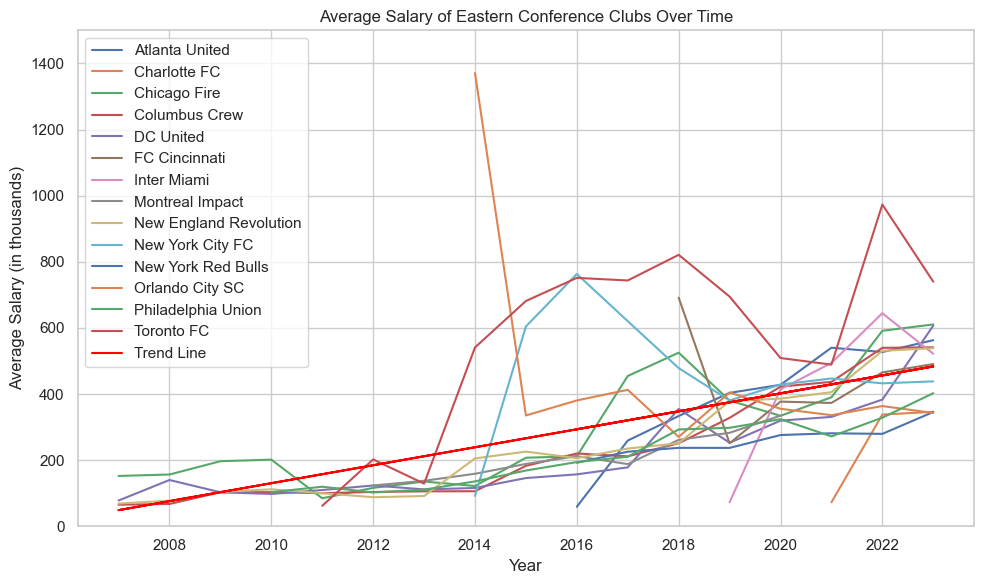

In [123]:
# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Eastern']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Eastern Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

### Question 9

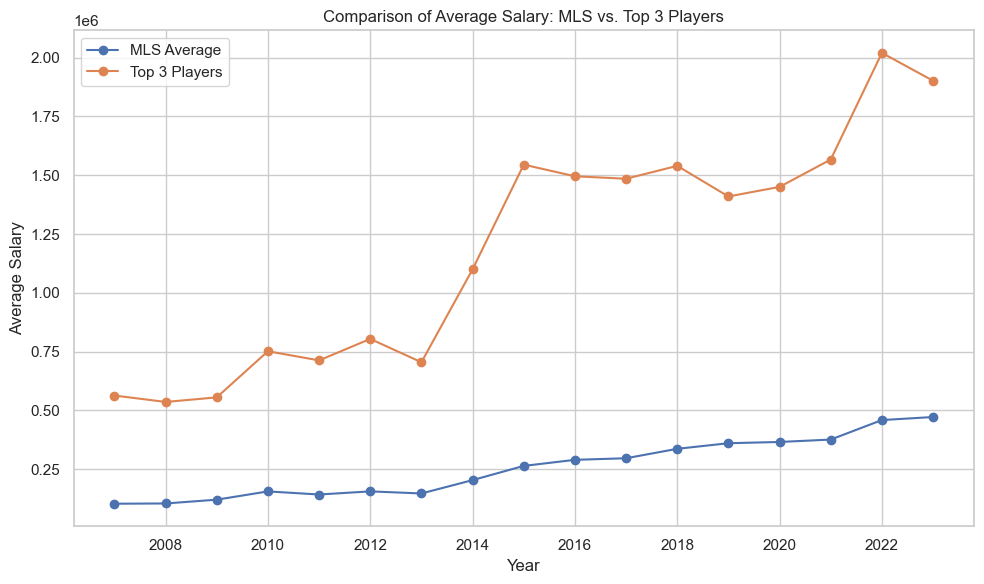

In [147]:
# Calculate average salary per year for the MLS
average_salary_mls = mls_salaries_df.groupby('year')['base_salary'].mean().reset_index()

# Calculate average salary per year for the top 3 players of each club
top_3_players = mls_salaries_df.groupby(['year', 'club']).apply(lambda x: x.nlargest(3, 'base_salary')).reset_index(drop=True)
average_salary_top_3 = top_3_players.groupby('year')['base_salary'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_salary_mls['year'], average_salary_mls['base_salary'], marker='o', label='MLS Average')
# average_salary_mls['base_salary'] /= 1_000_000
plt.plot(average_salary_top_3['year'], average_salary_top_3['base_salary'], marker='o', label='Top 3 Players')



plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Comparison of Average Salary: MLS vs. Top 3 Players')
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
annual_diff_percent = average_salary_top_3.apply(lambda x: x.pct_change() * 100)

# Create a DataFrame to display the results
diff_table = pd.DataFrame({'Year': average_salary_mls.year,
                           'Rate of Change (%)': annual_diff_percent.base_salary})

# Display the table
print(diff_table)

    Year  Rate of Change (%)
0   2007                 NaN
1   2008           -4.836154
2   2009            3.628682
3   2010           35.286734
4   2011           -5.170279
5   2012           12.800847
6   2013          -12.341309
7   2014           56.066537
8   2015           40.429780
9   2016           -3.206144
10  2017           -0.701120
11  2018            3.691835
12  2019           -8.454203
13  2020            2.891127
14  2021            8.024720
15  2022           28.929965
16  2023           -5.866156


### Question 10

In [153]:
mls_salaries_2023_df.base_salary.mean()

472225.5074798619